# Depth Space --> Density Space

In [4]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
from importlib import reload
from cmocean import cm as cmo
import argopy
import glidertools as gt

In [5]:
import filt_funcs as ff
import EV_funcs as ef
import plot_funcs as pf
import density_funcs as df

In [187]:
reload(ff)
reload(ef)
reload(pf)
reload(df)

<module 'density_funcs' from '/home.ufs/amf2288/argo-intern/density_funcs.py'>

In [7]:
s_ds=xr.open_dataset("202206/202206_lon:(25,45)_lat:(-60,-50).nc")
s = ff.get_ds_interp(s_ds,0,2000,4)
s['SPICE'] = gsw.spiciness0(s.SA,s.CT).rename('SPICE')

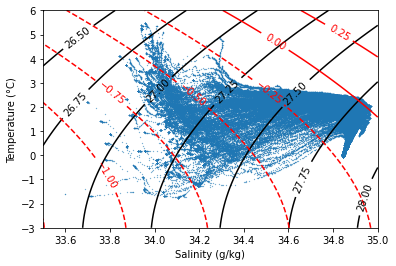

In [8]:
ds_li=[s]
Taxis=[-3,6,50]
Saxis=[33.5,35,50]

pf.plot_TS(ds_li, Taxis, Saxis)

In [9]:
rho_grid = np.linspace(26.5,28,1001)

In [ ]:
s_rho = df.interpolate2density_prof(s, rho_grid)

50
100
150
200
250
300


In [ ]:
import scipy.interpolate as interpolate

def func_var_int(ds, var, rho_grid, flag='group'):
    
    N_PROF_num = ds['N_PROF_NEW'].values
    
    rho = ds.SIG0
    rho_nonan = rho.where(~np.isnan(rho), drop=True)
    
    var_nonan = ds[var].where(~np.isnan(rho), drop=True)
    
    var_nonan2 = var_nonan.where(~np.isnan(var_nonan), drop=True)
    
    if flag == 'group': # incase density is identical b/w two points (this makes things very slow)
        var_nonan = var_nonan.groupby(rho_nonan).mean()
        rho_nonan = rho_nonan.groupby(rho_nonan).mean()
    
    if (len(rho_nonan)>2) & (len(var_nonan2)>2):
        fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    
        var_tilde = fvar(rho_grid)
    else:
        var_tilde = np.nan*rho_grid
    
    return xr.DataArray(var_tilde.reshape((-1,1)),
                        dims = ['rho_grid', 'N_PROF_NEW'],
                        coords = {'rho_grid': rho_grid, 'N_PROF_NEW': [N_PROF_num]}).rename(var)

In [ ]:
def interpolate2density(ds_z):
    
    N_PROF_ind = 0
    pres_tilde_xr  = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'PRES_INTERPOLATED',rho_grid)
    CT_tilde_xr    = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'CT',rho_grid)
    SA_tilde_xr    = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SA', rho_grid)
    SIG0_tilde_xr  = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SIG0', rho_grid)
    SPICE_tilde_xr = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SPICE', rho_grid)

    for N_PROF_ind in range(1, len(ds_z.N_PROF)):
        if np.mod(N_PROF_ind, 50)==0:
            print(N_PROF_ind)
        pres_tilde_xr  = xr.concat([pres_tilde_xr , func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'PRES_INTERPOLATED', rho_grid)], dim='N_PROF_NEW')
        CT_tilde_xr    = xr.concat([CT_tilde_xr , func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'CT', rho_grid)], dim='N_PROF_NEW')
        SA_tilde_xr    = xr.concat([SA_tilde_xr , func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SA', rho_grid)], dim='N_PROF_NEW')
        SIG0_tilde_xr  = xr.concat([SIG0_tilde_xr , func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SIG0', rho_grid)], dim='N_PROF_NEW')
        SPICE_tilde_xr = xr.concat([SPICE_tilde_xr , func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SPICE', rho_grid)], dim='N_PROF_NEW')
    

    ds_rho = xr.merge([pres_tilde_xr, CT_tilde_xr,
                             SA_tilde_xr, SIG0_tilde_xr, SPICE_tilde_xr])
    
    return ds_rho

In [ ]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 10

In [ ]:
#why is the colorbar y axis switched? that didn't happen with the temperature plot below

plt.figure(figsize=(10,3))
s.SIG0.plot(y='PRES_INTERPOLATED',x='N_PROF_NEW',cmap=cmo.dense, rasterized=True)
s.SIG0.plot.contour(y='PRES_INTERPOLATED',x='N_PROF_NEW',levels=[26.5,26.75,27,27.25,27.5,27.75,28], 
                     colors='w', linewidths=0.5)
plt.gca().invert_yaxis()
plt.title('DEPTH SPACE: Density with Density Contours');

In [ ]:
plt.figure(figsize=(10,3))
s.CT.plot(y='PRES_INTERPOLATED',x='N_PROF_NEW',
           cmap=cmo.thermal, rasterized=True, cbar_kwargs={'label': 'Temperature [$^o$C]'})
s.SIG0.plot.contour(y='PRES_INTERPOLATED',x='N_PROF_NEW',levels=[26.5,26.75,27,27.25,27.5,27.75,28], 
                     colors='b', linewidths=0.5)
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED')
plt.xlabel('N_PROF_NEW')
plt.title('DEPTH SPACE: Temperature with Density Contours');

In [ ]:
plt.figure(figsize=(10,3))

s_rho.CT.plot(y='rho_grid', x='N_PROF_NEW',
               cmap=cmo.thermal, rasterized=True, cbar_kwargs={'label': 'Temperature [$^o$C]'})
plt.hlines([26.5,26.75,27,27.25,27.5,27.75,28],0, 350, linewidths=0.5, colors='b')
plt.gca().invert_yaxis()
plt.ylim(27.9,26.8)
plt.title('DENSITY SPACE: Temperature with Density Contours');

In [79]:
def func_var_int_pmean(ds, var, Pmean_smooth): 
    Pmean_grid = np.linspace(0,1000,501)
    
    ds_nonan = ds[var].where(~np.isnan(ds[var]) & ~np.isnan(Pmean_smooth), drop=True)
    
    Pmean_nonan = Pmean_smooth.where(~np.isnan(ds[var]) & ~np.isnan(Pmean_smooth), drop=True)
    
    if len(ds_nonan) > 2:
       
        f = interpolate.PchipInterpolator(Pmean_nonan.values, ds_nonan.values , extrapolate=False)
        
        ds_on_Pmean = f(Pmean_grid)
            
        
    else:
        ds_on_Pmean = np.nan*Pmean_grid
    
    return xr.DataArray(ds_on_Pmean.reshape((-1,1)),
                        dims = ['Pmean', 'N_PROF_NEW'],
                        coords = {'Pmean': Pmean_grid, 'N_PROF_NEW': [ds.N_PROF_NEW.values]}).rename(var)

In [80]:
#Pmean  has rho_grid             coordinate
#so_rho has rho_grid, N_PROF_NEW coordinates

#TO SOLVE: broadcast PRES_INTERPOLATED to make copies of profile into multile 

In [224]:
s

<xarray.Dataset>
Dimensions:                (N_PROF: 335, PRES_INTERPOLATED: 1000)
Coordinates:
  * N_PROF                 (N_PROF) int64 1967 1968 1969 1970 ... 5848 5850 5913
    TIME                   (N_PROF) datetime64[ns] 2015-07-11T03:25:10 ... 20...
    LATITUDE               (N_PROF) float64 -52.29 -51.84 ... -50.81 -51.94
    LONGITUDE              (N_PROF) float64 25.93 27.78 28.84 ... 30.96 32.08
  * PRES_INTERPOLATED      (PRES_INTERPOLATED) int64 0 2 4 6 ... 1994 1996 1998
    N_PROF_NEW             (N_PROF) int64 0 1 2 3 4 5 ... 330 331 332 333 334
Data variables:
    CONFIG_MISSION_NUMBER  (N_PROF) int32 4 4 4 4 4 4 4 4 ... 5 5 14 10 10 10 13
    CT                     (N_PROF, PRES_INTERPOLATED) float64 0.9924 ... 1.098
    CYCLE_NUMBER           (N_PROF) int32 56 57 58 59 60 ... 169 151 153 155 247
    DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    DIRECTION              (N_PROF) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_PROF) int32 1901700 1901700 ... 7900203 7900305
    PRES                   (N_PROF, PRES_INTERPOLATED) float32 1.1 ... 1.998e+03
    PSAL                   (N_PROF, PRES_INTERPOLATED) float32 34.0 ... 34.73
    SA                     (N_PROF, PRES_INTERPOLATED) float64 34.16 ... 34.9
    SIG0                   (N_PROF, PRES_INTERPOLATED) float64 27.24 ... 27.83
    TEMP                   (N_PROF, PRES_INTERPOLATED) float32 0.988 ... 1.223
    SPICE                  (N_PROF, PRES_INTERPOLATED) float64 -0.6322 ... -0...
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /swot/SUM05/dbalwada/Argo_sync
    Fetched_by:           amf2288
    Fetched_date:         2023/04/01
    Fetched_constraints:  [x=25.00/45.00; y=-60.00/-50.00; z=0.0/2000.0]
    Fetched_uri:          /swot/SUM05/dbalwada/Argo_sync/dac/coriolis/6900750...
    history:              Variables filtered according to DATA_MODE; Variable...

In [83]:
ds = s_rho
N_PROF_NEW_ind=0
Pmean_smooth = s_rho.PRES_INTERPOLATED.mean('N_PROF_NEW').rolling(rho_grid= 80, center=True).mean()

Spice_on_Pmean = func_var_int_pmean(s_rho.isel(N_PROF_NEW=N_PROF_NEW_ind), 'SPICE', Pmean_smooth)

for N_PROF_NEW_ind in range(1, len(ds.N_PROF_NEW)):
    #print(distance_ind)
    if np.mod(N_PROF_NEW_ind, 10)==0:
        print(N_PROF_NEW_ind)
    Spice_on_Pmean = xr.concat([Spice_on_Pmean, func_var_int_pmean(s_rho.isel(N_PROF_NEW=N_PROF_NEW_ind), 'SPICE', Pmean_smooth)]
                              , dim='N_PROF_NEW')

10
20
30


ValueError: `x` must be strictly increasing sequence.

In [82]:
Pmean_smooth = s_rho.PRES_INTERPOLATED.mean('N_PROF_NEW').rolling(rho_grid= 80, center=True).mean()
Pmean_nonan = Pmean_smooth.where(~np.isnan(s_rho['SPICE']) & ~np.isnan(Pmean_smooth), drop=True)

ValueError: Dimensions {'N_PROF_NEW'} do not exist. Expected one or more of ('rho_grid',)

In [ ]:
plt.figure(figsize=(7.5,2.))
Spice_on_Pmean.plot(x='N_PROF_NEW',vmin=-1.5e-1, rasterized=True, #interpolation= None,
                           cbar_kwargs={'label': 'Spice Anomaly [kg m$^{-3}$]'})
plt.hlines(Pmean_smooth.sel(rho_grid=[27.1, 27.3, 27.5, 27.7], method='nearest').values,0, 1.7e6, 
          linewidths=0.3, colors='b')
plt.gca().invert_yaxis()

## Load Based on Float Profile

Wanted to take a look at a similar analysis as above, but for one float, with a "distance" axis instead of an "N_PROF" axis (more similar to a glider). I think I found the function Dhruv used to create the distance coordinate, interp_distance pasted below, but it also relies on the `glidertools` package, so I can't complete this unfortunately.

In [92]:
float_IDs = np.unique(s.PLATFORM_NUMBER)

In [201]:
float0 = ff.get_float(float_IDs[0], 4)

loading points complete
to xarray complete
point to profile complete
interpolation complete
adding spice complete


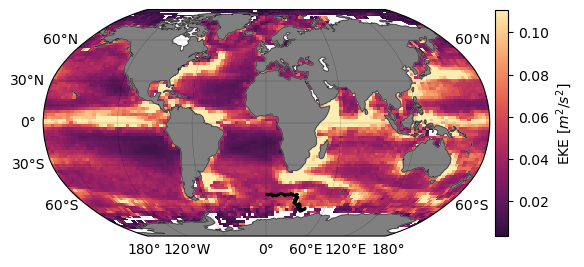

In [221]:
pf.plot_dist(float0)

In [196]:
float0_dist = df.interp_distance(float0)

In [218]:
rho_grid_0 = np.linspace(26.8,28,1001)

In [219]:
float0_rho = df.interpolate2density_dist(float0_dist, rho_grid_0)

50
100


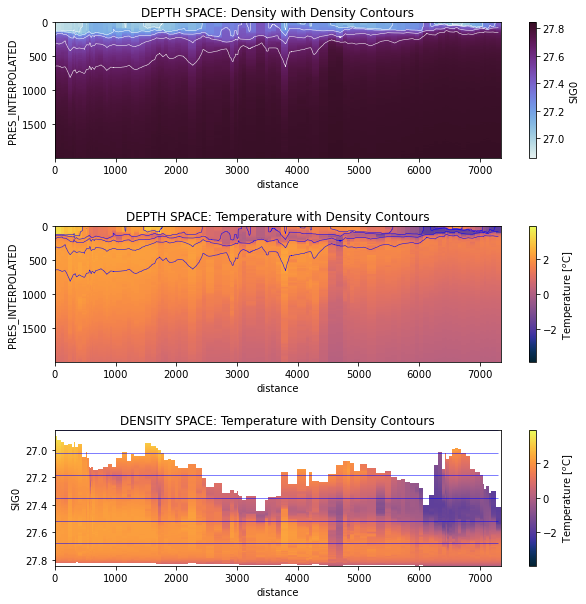

In [199]:
pf.plot_depth_profs(float0_dist, float0_rho, dim1='distance')

In [213]:
float2 = ff.get_float(float_IDs[2], 4)

loading points complete
to xarray complete
point to profile complete
interpolation complete
adding spice complete


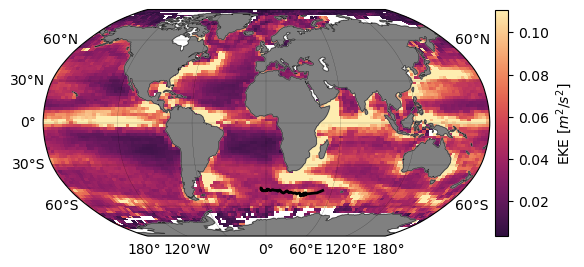

In [215]:
pf.plot_dist(float2)

In [216]:
float2_dist = df.interp_distance(float2)

In [222]:
rho_grid_2 = np.linspace(26.75,27.75,1001)

In [223]:
float2_rho = df.interpolate2density_dist(float2_dist, rho_grid_2)

50


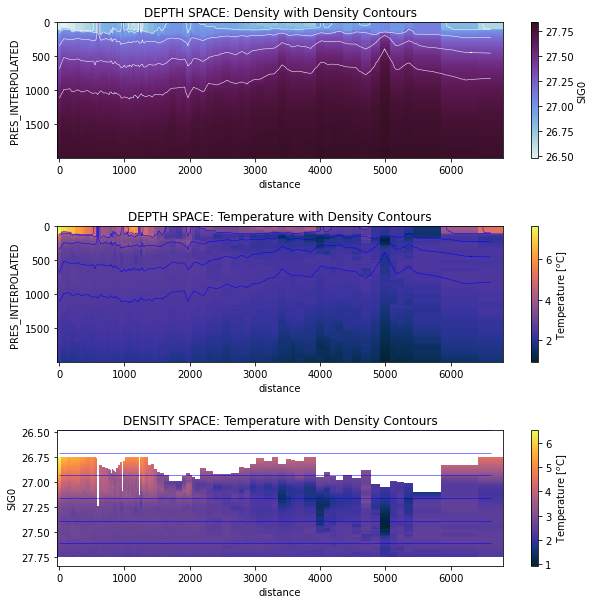

In [224]:
pf.plot_depth_profs(float2_dist, float2_rho, dim1='distance')